Note: make top line #!/usr/bin/env python

In [1]:
import subprocess
import os
import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates

In [2]:
def update_adj(array: np.ndarray, dataframe: pd.DataFrame):
    # Iterate through columns in the DataFrame
    for column_name in dataframe.columns:
        # Find the column name in the array
        start_index = np.where(array == column_name)[0]

        if len(start_index) == 0:
            print(f"Target string '{column_name}' not found in the array.")
            continue

        start_index = start_index[0]

        # Find the index of the next '####'
        end_index = np.where(array == '####')[0]

        if len(end_index) == 0:
            print("No '####' found after the target string.")
            continue

        end_index = end_index[np.where(end_index > start_index)]

        if len(end_index) == 0:
            print("No '####' found after the target string.")
            continue

        end_index = end_index[0]

        # Skip the first 5 lines for nmonths
        start_index += 6

        # Save the range between start and end index to a NumPy array
        result_array = np.arange(start_index, end_index + 1)

        # Iterate through rows in the DataFrame
        for row_index in dataframe.index:
            # Map row_index to the corresponding index in result_array
            index_to_update = (row_index - 1) * 12

            if index_to_update < 0 or index_to_update + 11 >= len(array):
                print(f"Index value '{row_index}' is out of range for '{column_name}'. Skipping.")
                continue

            # Convert the array values to numeric before performing multiplication
            array_values_numeric = pd.to_numeric(array[result_array[index_to_update:index_to_update + 12]])

            # Perform updates by multiplying the array value by the corresponding one in the DataFrame
            for i in range(12):
                array[result_array[index_to_update + i]] = array_values_numeric[i] * dataframe.at[row_index, column_name]

    return array

In [3]:
def remove_invalid_values(simulated, observed):
    valid_indices = np.where((observed != -9999) & (simulated != -9999))
    return simulated[valid_indices], observed[valid_indices]


In [4]:
def remove_nan_rows(
    array1: np.ndarray, 
    array2: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Removes rows from two arrays where either array has NaN values.
    Retains the first row if it doesn't have any NaN values.
    
    Arguments:
    array1: np.ndarray:
        First input array
    array2: np.ndarray
        Second input array
    
    Returns:
    cleaned_array1: : np.ndarray
        Cleaned array1 without NaN rows
    cleaned_array2: np.ndarray
        Cleaned array2 without NaN rows
    """
    # checks for and removes any rows where either array has a value of NaN at a corresponding row 
    # including the first one
    
    mask = np.logical_and(~np.isnan(array1), ~np.isnan(array2))
    if not np.isnan(array1[0]) and not np.isnan(array2[0]):
        mask[0] = True
    cleaned_array1 = array1[mask]
    cleaned_array2 = array2[mask]
    return cleaned_array1, cleaned_array2

In [5]:
def compute_kge(simulated_array, observed_array):
    """
    Computes KGE (Kling-Gupta Efficiency) between observed and simulated values.

    Parameters:
        observed_array (numpy.ndarray): Array of observed values.
        simulated_array (numpy.ndarray): Array of simulated values.

    Returns:
        float: KGE value.
    """
    
    # Calculate Pearson correlation coefficient
    correlation_coefficient = np.corrcoef(observed_array, simulated_array)[0, 1]
    
    # Calculate standard deviation ratio
    std_observed = np.std(observed_array)
    std_simulated = np.std(simulated_array)
    std_ratio = std_simulated / std_observed
    
    # Calculate bias ratio
    mean_observed = np.mean(observed_array)
    mean_simulated = np.mean(simulated_array)
    bias_ratio = mean_simulated / mean_observed
    
    # Calculate KGE
    kge = 1 - np.sqrt((correlation_coefficient - 1)**2 + (std_ratio - 1)**2 + (bias_ratio - 1)**2)
    return kge

In [6]:
def compute_bias(simulated_array, observed_array):
    """
    Computes bias between observed and simulated values.

    Parameters:
        observed_array (numpy.ndarray): Array of observed values.
        simulated_array (numpy.ndarray): Array of simulated values.

    Returns:
        float: Bias value.
    """
    
    # Calculate mean bias
    mean_observed = np.mean(observed_array)
    mean_simulated = np.mean(simulated_array)
    
    # Calculate bias
    bias = mean_simulated - mean_observed
       
    # Calculate percent bias
    percent_bias = (bias / mean_observed) * 100
    
    return percent_bias

In [7]:
# Specify the directory where your executable is located
executable_directory = '../../model/'

In [8]:
# Change the current working directory to the specified directory
os.chdir(executable_directory)

# run prms
subprocess.run(['./prms', '-C./control.default.bandit'])

### Inputs

In [9]:
# Create an empty list to store total KGE values for each file
calibrate_kge  = []

In [10]:
validate_kge= []

In [11]:
calibrate_bias= []

In [12]:
validate_bias= []

In [13]:
file_names = []

In [14]:
calibration = [('1981-01-01', '1984-12-31'),
               ('1990-01-01', '1998-12-31'),
               ('2004-01-01', '2007-12-31'),
               ('2013-01-01', '2015-12-31')]

In [15]:
validation = [('1985-01-01', '1989-12-31'),
               ('1999-01-01', '2003-12-31'),
               ('2008-01-01', '2012-12-31')]

### Read statvar

In [16]:
    # Read space-separated file into DataFrame, skipping 28 rows
simulated = pd.read_csv('./statvar.out', sep=' ', skiprows=29, header=None)

In [17]:
# Drop the specified columns
columns_to_drop = [0, 4, 5, 6, len(simulated.columns) - 1]  # 0-based index of columns to drop
simulated = simulated.drop(columns=columns_to_drop, axis=1)

In [18]:
# Combine the first 3 columns as datetime
simulated['date'] = pd.to_datetime(simulated.iloc[:, :3].astype(str).agg('-'.join, axis=1))

In [19]:
# Set the new 'date' column as the index
simulated.set_index('date', inplace=True)

In [20]:
# Drop the original three columns
simulated = simulated.drop(simulated.columns[:3], axis=1)

In [21]:
# Filter the DataFrame to keep only rows within the specified year ranges
cal_simulated_filtered = pd.concat([simulated.loc[start_date:end_date] for start_date, end_date in calibration])

In [22]:
# Filter the DataFrame to keep only rows within the specified year ranges
val_simulated_filtered = pd.concat([simulated.loc[start_date:end_date] for start_date, end_date in validation])

### Read infilled

In [23]:
# Read space-separated file into DataFrame, skipping 28 rows
infill = pd.read_csv('./infill_sf_data', sep=' ', skiprows=23, header=None)

In [24]:
# Drop the specified columns
columns_to_drop = [3, 4, 5]  # 0-based index of columns to drop
infill = infill.drop(columns=columns_to_drop, axis=1)

In [25]:
# Combine the first 3 columns as datetime
infill['date'] = pd.to_datetime(infill.iloc[:, :3].astype(str).agg('-'.join, axis=1))

In [26]:
# Set the new 'date' column as the index
infill.set_index('date', inplace=True)

In [27]:
# Drop the original three columns
drop = [0, 1, 2]  # 0-based index of columns to drop
infill = infill.drop(columns=drop, axis=1)

In [28]:
# Filter the DataFrame to keep only rows within the specified year ranges
cal_infill_filtered = pd.concat([infill.loc[start_date:end_date] for start_date, end_date in calibration])

In [29]:
# Filter the DataFrame to keep only rows within the specified year ranges
val_infill_filtered = pd.concat([infill.loc[start_date:end_date] for start_date, end_date in validation])

### Metrics

In [30]:
for column_index in range(0, 14):  
    # Extract the simulated and observed arrays
    simulated_array1 = cal_simulated_filtered.iloc[:, column_index].values
    observed_array1 = cal_infill_filtered.iloc[:, column_index].values

    # Remove invalid values (-9999) after concatenating arrays
    simulated_array1, observed_array1 = remove_invalid_values(simulated_array1, observed_array1)

    # Check for and remove rows with nan
    simulated_array1, observed_array1 = remove_nan_rows(simulated_array1, observed_array1)

    # Check if both arrays have the same length
    if len(observed_array1) != len(simulated_array1):
        raise ValueError("Observed and simulated data arrays have different lengths!")

    # Calculate KGE for the specified pair of columns
    total_kge = compute_kge(simulated_array1, observed_array1)
    
    cal_bias= compute_bias(simulated_array1, observed_array1)

    # Save total KGE to the list
    calibrate_kge.append(total_kge)
    
    calibrate_bias.append(cal_bias)

    # Extract the simulated and observed arrays
    simulated_array2 = val_simulated_filtered.iloc[:, column_index].values
    observed_array2 = val_infill_filtered.iloc[:, column_index].values

    # Remove invalid values (-9999) after concatenating arrays
    simulated_array2, observed_array2 = remove_invalid_values(simulated_array2, observed_array2)

    # Check for and remove rows with nan
    simulated_array2, observed_array2 = remove_nan_rows(simulated_array2, observed_array2)

    # Check if both arrays have the same length
    if len(observed_array2) != len(simulated_array2):
        raise ValueError("Observed and simulated data arrays have different lengths!")

    # Calculate KGE for the specified pair of columns
    val_kge = compute_kge(simulated_array2, observed_array2)
    
    val_bias = compute_bias(simulated_array2, observed_array2)

    # Save total KGE to the list
    validate_kge.append(val_kge)
    
    validate_bias.append(val_bias)

In [31]:
gauge_names= ['Swiftcurrent Creek at Sherburne Reservoir','St. Mary River near Babb, MT',
              'St. Mary River at International Boundary', 'Milk River at Western Crossing of International Boundary',
              'North Fork Milk River above St Mary Canal near Browning','Milk River at Eastern Crossing',
              'Big Sandy Creek at Mouth','Clear Creek at Mouth','Lodge Creek at International Boundary',
              'Battle Creek at International Boundary','Peoples Creek at Mouth',
              'Frenchman River at International Boundary', 'Beaver Creek Bowdoin','Rock Creek at Mouth']


In [32]:
results= pd.DataFrame(index=gauge_names)

In [33]:

# Populate the 'Cal KGE' column with calibrate_kge array
results['Cal KGE'] = calibrate_kge

# Populate the 'Val KGE' column with validate_kge array
results['Val KGE'] = validate_kge

results['Cal Bias'] = calibrate_bias

results['Val Bias'] = validate_bias



In [34]:
results

,Cal KGE,Val KGE,Cal Bias,Val Bias
Swiftcurrent Creek at Sherburne Reservoir,0.211591,0.249278,-59.043585,-55.999335
"St. Mary River near Babb, MT",0.774562,0.817145,-17.330391,-12.269446
St. Mary River at International Boundary,0.808072,0.861406,-14.306134,-7.281741
Milk River at Western Crossing of International Boundary,0.647060,0.647159,5.410058,20.085010
North Fork Milk River above St Mary Canal near Browning,0.626816,0.538040,-10.395460,1.707821
Milk River at Eastern Crossing,0.593923,-1.144026,6.028003,78.863608
Big Sandy Creek at Mouth,-0.162140,-4.613621,95.728382,338.883192
Clear Creek at Mouth,-1.967690,-0.487347,85.761309,68.569049
Lodge Creek at International Boundary,-0.463109,-3.226865,118.600294,380.834935
Battle Creek at International Boundary,-1.574618,-4.609802,189.456534,382.257611


In [35]:
# Save the DataFrame to a CSV file
results.to_csv('../model/plots/performance_metrics.csv', index=True)

### Plot Hydrograph

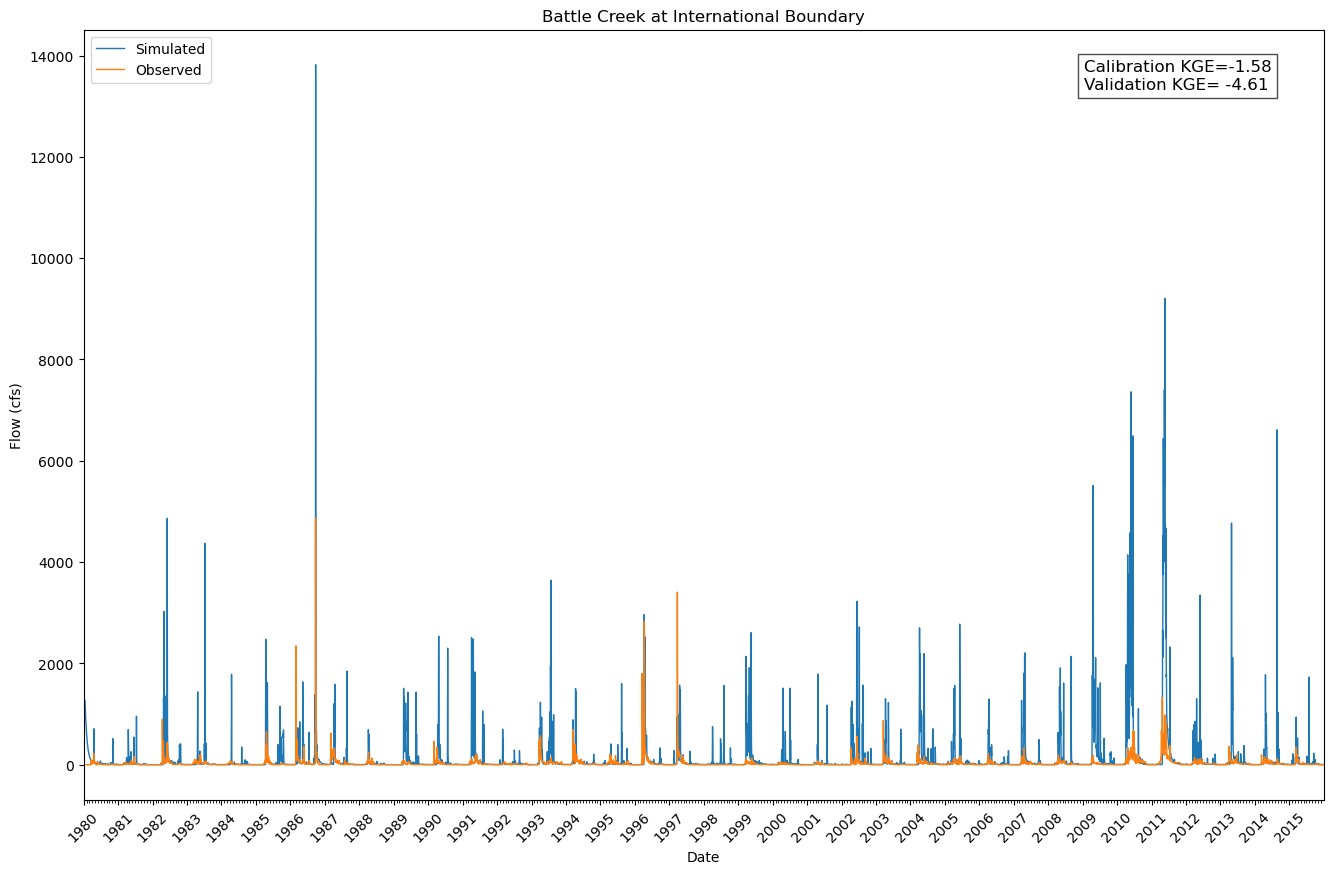

In [36]:
# Plotting columns 1 and 2 against the index
column_plot = 9

column_name_1 = simulated.columns[column_plot]
column_name_2 = infill.columns[column_plot]

# Replace any value of -9999 in column_name_2 with 0
infill[column_name_2].replace(-9999, 0, inplace=True)

# Plotting columns 1 and 2 against the index with no markers
plt.figure(figsize=(16, 10))  # Adjust the figure size as needed
plt.plot(simulated.index, simulated[column_name_1], linestyle='-', linewidth=1, label='Simulated')
plt.plot(infill.index, infill[column_name_2], linestyle='-', linewidth=1, label='Observed')

# Set x-axis limits to trim by dates
start_date = datetime.datetime(1980, 1, 1)
end_date = datetime.datetime(2015, 12, 31)
plt.xlim(start_date, end_date)

# Adjusting y-axis limits to make the scale smaller
# plt.ylim(0, 10000)  # Adjust the limits as needed

plt.xlabel('Date')
plt.ylabel('Flow (cfs)')
plt.title('Battle Creek at International Boundary')

# Add minor ticks to the x-axis (every month)
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator())

# Tilt the x labels by 45 degrees and label every year
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Move the legend to the top left
plt.legend(loc='upper left')

# Add KGE value as a new plot element
kge_text = 'Calibration KGE=-1.58\nValidation KGE= -4.61'
plt.gcf().text(0.75, 0.85, kge_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7), verticalalignment='top')

# Save the plot to a file
plt.savefig('../model/plots/btcib.png')

plt.show()